In [70]:
import pandas as pd
import joblib
import json
from IPython.display import display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt

def load_config(config_file="../config.json"):
    """Load configuration from a JSON file."""
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

In [71]:
test_df = pd.read_csv('../outputs/test_df.csv')

In [72]:
test_df

,projectid,total_price_excluding_optional_support,students_reached,fully_funded,date_posted,total_projects_in_city,total_projects_in_state,percentage_reached_month_1,percentage_reached_month_2,percentage_reached_month_3,...,month_posted_December,month_posted_February,month_posted_January,month_posted_July,month_posted_June,month_posted_March,month_posted_May,month_posted_November,month_posted_October,month_posted_September
0,a11d5c86692ef20e9f702094504bb5db,387.13,34.0,1.0,2013-01-01,290,126242,0.000000,0.000000,0.000000,...,False,False,True,False,False,False,False,False,False,False
1,8bdc6b4cfc850f6f7cc3963c48ba454b,1045.00,120.0,0.0,2013-01-01,172,2127,8.133971,8.133971,8.133971,...,False,False,True,False,False,False,False,False,False,False
2,88f263f1cd657bccce254ffc0b79df4d,868.02,28.0,1.0,2013-01-01,102,126242,100.000000,100.000000,100.000000,...,False,False,True,False,False,False,False,False,False,False
3,a8a6e08b6ae7ab1a88c16ba82ac8e9da,515.00,96.0,1.0,2013-01-01,206,14853,100.000000,100.000000,100.000000,...,False,False,True,False,False,False,False,False,False,False
4,be21151602e4fd47dd4012114fd519c6,238.56,25.0,1.0,2013-01-01,337,18615,17.815225,100.000000,100.000000,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114032,a0e839f24645e3d6dcbd327f8441b043,567.18,60.0,1.0,2013-12-31,20364,73182,53.289961,100.000000,100.000000,...,True,False,False,False,False,False,False,False,False,False
114033,f820ef3537f4445b0716244fae36f763,277.37,30.0,0.0,2013-12-31,55,2030,0.000000,0.000000,0.000000,...,True,False,False,False,False,False,False,False,False,False
114034,95ee208a51831edffa7cc2e0aa3e83cd,202.34,98.0,1.0,2013-12-31,2945,9837,100.000000,100.000000,100.000000,...,True,False,False,False,False,False,False,False,False,False
114035,1aa5e1d739a40c2763da1a0bb0f0f335,177.18,23.0,1.0,2013-12-31,855,17299,100.000000,100.000000,100.000000,...,True,False,False,False,False,False,False,False,False,False


In [73]:
test_df.columns

Index(['projectid', 'total_price_excluding_optional_support',
       'students_reached', 'fully_funded', 'date_posted',
       'total_projects_in_city', 'total_projects_in_state',
       'percentage_reached_month_1', 'percentage_reached_month_2',
       'percentage_reached_month_3', 'poverty_level_high poverty',
       'poverty_level_highest poverty', 'poverty_level_low poverty',
       'poverty_level_moderate poverty', 'school_metro_rural',
       'school_metro_suburban', 'school_metro_urban', 'grade_level_Grades 3-5',
       'grade_level_Grades 6-8', 'grade_level_Grades 9-12',
       'grade_level_Grades PreK-2', 'primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       

In [74]:
test_df['date_posted'] = pd.to_datetime(test_df['date_posted'])

In [75]:
# Set max_date to filter projects posted for at least 3 months
fixed_max_date = pd.to_datetime('2013-12-31')
test_df['months_since_posted'] = ((fixed_max_date - test_df['date_posted']) / pd.Timedelta(days=30)).astype(int)
eligible_projects = test_df[test_df['months_since_posted'] >= 3].copy()

In [76]:
test_df.columns

Index(['projectid', 'total_price_excluding_optional_support',
       'students_reached', 'fully_funded', 'date_posted',
       'total_projects_in_city', 'total_projects_in_state',
       'percentage_reached_month_1', 'percentage_reached_month_2',
       'percentage_reached_month_3', 'poverty_level_high poverty',
       'poverty_level_highest poverty', 'poverty_level_low poverty',
       'poverty_level_moderate poverty', 'school_metro_rural',
       'school_metro_suburban', 'school_metro_urban', 'grade_level_Grades 3-5',
       'grade_level_Grades 6-8', 'grade_level_Grades 9-12',
       'grade_level_Grades PreK-2', 'primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       

In [77]:
config = load_config()
poverty_levels = ["low", "moderate", "high", "highest"]
models = ["random_forest", "logistic_regression"]
recommendations = {}
all_recommendations = pd.DataFrame()

In [78]:
# Copy of eligible_projects with all original columns
all_recommendations = eligible_projects.copy()

for model_type in models:
    for pov_level in poverty_levels:
        pov_column = f"poverty_level_{pov_level} poverty"
        
        # Filter projects matching the current poverty level
        pov_projects = eligible_projects[eligible_projects[pov_column] == 1].copy()
        
        # Load the classifier
        classifier = joblib.load(f"../outputs/{model_type}_{pov_level}_poverty.pkl")
        
        # Prepare the test data by dropping non-feature columns and reindexing to match model features
        X_test_filtered = pov_projects.drop(columns=['fully_funded', 'date_posted', 'months_since_posted', 'projectid'], errors='ignore')
        X_test_filtered = X_test_filtered.reindex(columns=classifier.feature_names_in_, fill_value=0)
        
        proba_column = f'proba_{model_type}'  # e.g., 'proba_random_forest' or 'proba_logistic_regression'
        pov_projects[proba_column] = classifier.predict_proba(X_test_filtered)[:, 1]
        
        # Update 'all_recommendations' with the calculated probabilities in separate columns
        all_recommendations.loc[pov_projects.index, proba_column] = pov_projects[proba_column]


In [79]:
all_recommendations

,projectid,total_price_excluding_optional_support,students_reached,fully_funded,date_posted,total_projects_in_city,total_projects_in_state,percentage_reached_month_1,percentage_reached_month_2,percentage_reached_month_3,...,month_posted_July,month_posted_June,month_posted_March,month_posted_May,month_posted_November,month_posted_October,month_posted_September,months_since_posted,proba_random_forest,proba_logistic_regression
0,a11d5c86692ef20e9f702094504bb5db,387.13,34.0,1.0,2013-01-01,290,126242,0.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,12,0.16,0.219156
1,8bdc6b4cfc850f6f7cc3963c48ba454b,1045.00,120.0,0.0,2013-01-01,172,2127,8.133971,8.133971,8.133971,...,False,False,False,False,False,False,False,12,0.25,0.200483
2,88f263f1cd657bccce254ffc0b79df4d,868.02,28.0,1.0,2013-01-01,102,126242,100.000000,100.000000,100.000000,...,False,False,False,False,False,False,False,12,1.00,0.982894
3,a8a6e08b6ae7ab1a88c16ba82ac8e9da,515.00,96.0,1.0,2013-01-01,206,14853,100.000000,100.000000,100.000000,...,False,False,False,False,False,False,False,12,1.00,0.993049
4,be21151602e4fd47dd4012114fd519c6,238.56,25.0,1.0,2013-01-01,337,18615,17.815225,100.000000,100.000000,...,False,False,False,False,False,False,False,12,1.00,0.997940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76298,92008258a5af63dcaedf45a6ba930856,882.60,35.0,1.0,2013-10-02,35,126242,100.000000,100.000000,100.000000,...,False,False,False,False,False,True,False,3,1.00,0.964210
76299,12f6f130b4595c2387cf0a588f6e084d,504.84,25.0,1.0,2013-10-02,102,43478,100.000000,100.000000,100.000000,...,False,False,False,False,False,True,False,3,1.00,0.993040
76300,f1a12041e191265ada62787b032f84ed,324.50,28.0,1.0,2013-10-02,18247,73182,0.000000,0.000000,100.000000,...,False,False,False,False,False,True,False,3,0.98,0.997997
76301,792345c61483e1d4ff14fc72dccf586d,1140.11,30.0,0.0,2013-10-02,613,4519,0.745542,0.745542,0.745542,...,False,False,False,False,False,True,False,3,0.27,0.120264


In [80]:
top_recommendations = {}

poverty_levels = ["low", "moderate", "high", "highest"]

for pov_level in poverty_levels:
    pov_column = f"poverty_level_{pov_level} poverty"
    
    # Filter the DataFrame for the current poverty level
    pov_projects = all_recommendations[all_recommendations[pov_column] == 1]
    
    # Set the number of projects to select based on the poverty level
    top_n = 10 if pov_level in ["high", "highest"] else 3
    
    top_rf = pov_projects.nlargest(top_n, 'proba_random_forest').copy()
    top_recommendations[(pov_level, 'random_forest')] = top_rf 
    top_logistic = pov_projects.nlargest(top_n, 'proba_logistic_regression').copy()
    top_recommendations[(pov_level, 'logistic_regression')] = top_logistic

In [81]:
top_recommendations[('high', 'random_forest')].columns

Index(['projectid', 'total_price_excluding_optional_support',
       'students_reached', 'fully_funded', 'date_posted',
       'total_projects_in_city', 'total_projects_in_state',
       'percentage_reached_month_1', 'percentage_reached_month_2',
       'percentage_reached_month_3', 'poverty_level_high poverty',
       'poverty_level_highest poverty', 'poverty_level_low poverty',
       'poverty_level_moderate poverty', 'school_metro_rural',
       'school_metro_suburban', 'school_metro_urban', 'grade_level_Grades 3-5',
       'grade_level_Grades 6-8', 'grade_level_Grades 9-12',
       'grade_level_Grades PreK-2', 'primary_focus_subject_Applied Sciences',
       'primary_focus_subject_Character Education',
       'primary_focus_subject_Civics & Government',
       'primary_focus_subject_College & Career Prep',
       'primary_focus_subject_Community Service', 'primary_focus_subject_ESL',
       'primary_focus_subject_Early Development',
       'primary_focus_subject_Economics',
       

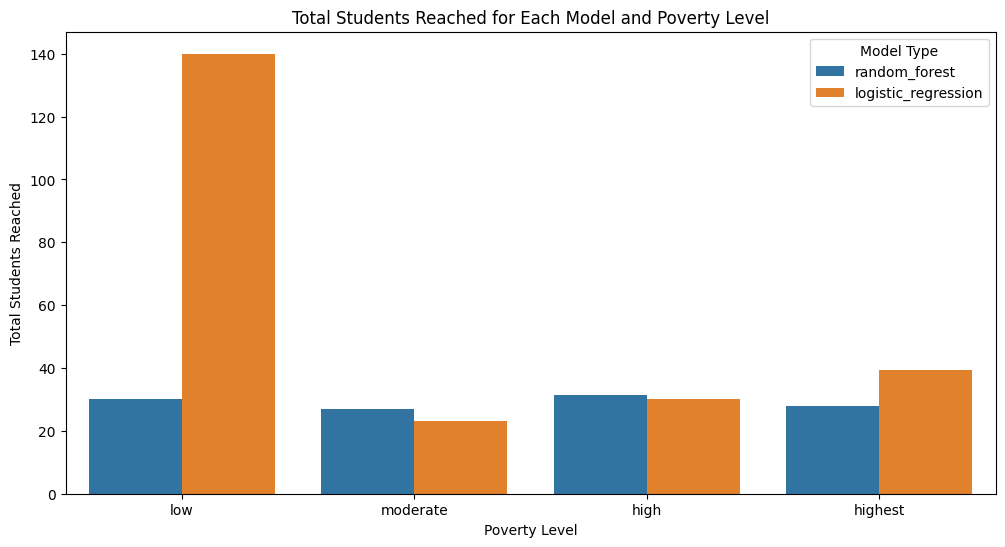

In [82]:
data = []

for (pov_level, model_type), df in top_recommendations.items():
    total_students_reached = df['students_reached'].median()
    data.append({
        'poverty_level': pov_level,
        'model_type': model_type,
        'students_reached': total_students_reached
    })

# Convert to a DataFrame for Seaborn
plot_df = pd.DataFrame(data)

# Set up the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x='poverty_level', y='students_reached', hue='model_type')

# Customize plot aesthetics
plt.title('Total Students Reached for Each Model and Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Total Students Reached')
plt.legend(title='Model Type')
plt.show()

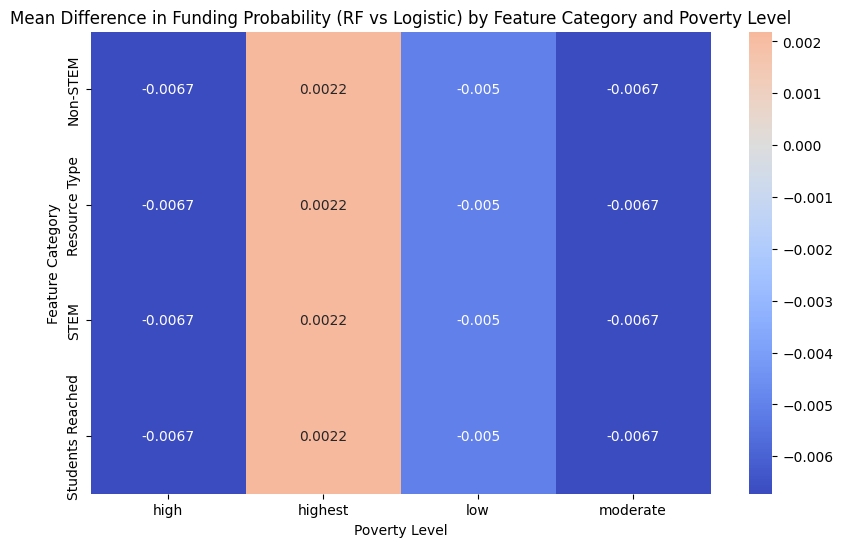

In [84]:
feature_categories = {
    'STEM': [
        'primary_focus_subject_Applied Sciences', 
        'primary_focus_subject_Environmental Science', 
        'primary_focus_subject_Health & Life Science',
        'primary_focus_subject_Mathematics',
        'primary_focus_subject_Nutrition',
        'primary_focus_subject_Health & Wellness'
    ],
    'Non-STEM': [
        col for col in all_recommendations.columns if col.startswith('primary_focus_subject_') 
        and col not in [
            'primary_focus_subject_Applied Sciences', 
            'primary_focus_subject_Environmental Science', 
            'primary_focus_subject_Health & Life Science',
            'primary_focus_subject_Mathematics',
            'primary_focus_subject_Nutrition',
            'primary_focus_subject_Health & Wellness'
        ]
    ],
    'Resource Type': [col for col in all_recommendations.columns if col.startswith('resource_type_')],
    'Students Reached': ['students_reached']
}

poverty_levels = ["low", "moderate", "high", "highest"]

heatmap_data = []

for pov_level in poverty_levels:
    for category, features in feature_categories.items():
        pov_data = all_recommendations[all_recommendations[f'poverty_level_{pov_level} poverty'] == 1]
        rf_log_diff = pov_data['proba_random_forest'] - pov_data['proba_logistic_regression']
        mean_diff = rf_log_diff.mean()  # Mean difference in funding probability for this category
        
        heatmap_data.append({
            'poverty_level': pov_level,
            'feature_category': category,
            'mean_difference': mean_diff
        })

heatmap_df = pd.DataFrame(heatmap_data)

heatmap_pivot = heatmap_df.pivot(index="feature_category", columns="poverty_level", values="mean_difference")

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_pivot, annot=True, cmap="coolwarm", center=0)
plt.title('Mean Difference in Funding Probability (RF vs Logistic) by Feature Category and Poverty Level')
plt.xlabel('Poverty Level')
plt.ylabel('Feature Category')
plt.savefig('../outputs/funding_probability_difference_heatmap.png', format='png', dpi=300, bbox_inches='tight')